In [1]:
# 필수 라이브러리 불러오기 

import numpy as np
from math import sqrt, pi

from qiskit import *
from qiskit.visualization import plot_histogram, plot_distribution, plot_error_map
from qiskit.visualization.array import array_to_latex
from qiskit.quantum_info import Operator, Statevector, random_statevector

from qiskit_ibm_provider import IBMProvider

from qiskit_aer import AerSimulator, StatevectorSimulator

import matplotlib.pyplot as plt

In [2]:
#IBMProvider.save_account("Your_Token", overwrite=True)
#provider = IBMProvider()

#수업을 위해 추가된 허브와 그룹, 프로젝트를 프로바이더에 설정
provider = IBMProvider(instance="ibm-q-education/ibm-quantum-1/hallimu")

In [3]:
provider.backends() #5 27Q Backends

[<IBMBackend('ibmq_belem')>,
 <IBMBackend('ibmq_lima')>,
 <IBMBackend('ibmq_manila')>,
 <IBMBackend('ibmq_qasm_simulator')>,
 <IBMBackend('ibmq_quito')>,
 <IBMBackend('ibm_lagos')>,
 <IBMBackend('ibm_perth')>,
 <IBMBackend('ibmq_jakarta')>]

수업을 위해 제공되는 백엔드들 중 가장 적은 Queue를 지닌 백엔드를 찾아 실습을 위한 백엔드로 설정합니다. 

In [5]:
from qiskit_ibm_provider import least_busy

backend = least_busy(provider.backends())
backend

<IBMBackend('ibm_lagos')>

### 새로운 양자 게이트 - RY

#### 표준 회전 게이트들

표준 회전 게이트들은 블로흐 구면의 $X, Y, Z$축을 기준으로 하는 회전 연산자들로 정의됩니다.

#### RY 게이트

RY 게이트는 Y축을 중심으로 큐비트의 상태를 주어진 $\theta$만큼 회전하는 연산자 입니다. 

$$
R_y(\theta) =
\begin{pmatrix}
\cos(\theta/2) & - \sin(\theta/2)\\
\sin(\theta/2) & \cos(\theta/2)
\end{pmatrix})
$$

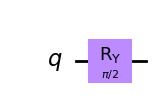

In [4]:
ry_gate = QuantumCircuit(1)
ry_gate.ry(np.pi/2,0)
ry_gate.draw(output='mpl')

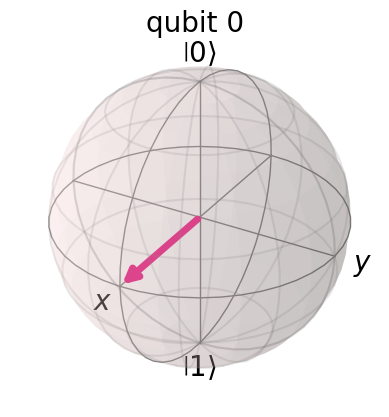

In [6]:
Statevector(ry_gate).draw('bloch')

## 불량배의 대장이 여러분에게 보여 준 것
(contents from: [The Quantum Enigmas 004 - The Monty Hall problem](https://www.youtube.com/watch?v=Hd9KhRts1uw) of Institut quantique de l'Université de Sherbrooke)


불량배의 대장 앞에는 세개의 금고가 있습니다.

<img src="img/enigma2.png" alt="Alternative text" width=800/>

그리고 여러분께 이야기 합니다.

너의 구슬은 이 금고중 하나에 숨겨져 있다. 네가 한번에 찾으면 돌려 줄 것이고 찾이 못하면 영원히 나의 것이다.

여러분은 고민끝에 2번을 선택했습니다. 불량배의 대장은 남은 두 개 중 하나인 1번 금고의 문을 열어서 당신에게 보여줍니다. 구슬이 들어있지 않네요!

이제 불량배 대장은 당신에게 질문합니다.

"선택을 바꿀 기회를 한번 주겠다. 너의 선택을 바꾸겠느냐?"

여러분의 선택은 무엇입니까?


### 1단계, 구슬이 숨겨진 금고의 상태를 만들어 보자.

구슬은 세개의 금고중 하나에 숨겨져 있습니다. 1번째 금고에 구슬이 숨겨져 있는 상태를 $|001\rangle$, 2번째 금고에 구슬이 숨겨져 있는 상태를 $|010\rangle$, 3번째 금고에 구슬이 숨겨져 있는 상태를 $|100\rangle$이라 한다면 양자 회로의 초기 상태는 이 세가지 상태가 모두 같은 확률로 존재하는 상태일 것입니다. 
$$|\psi_0\rangle  = \frac{1}{\sqrt{3}}(|001\rangle + |010\rangle + |100\rangle)$$

가장 먼저, 0번째 큐비트의 상태가 1로 측정될 확률이 1/3, 0으로 측정될 확률이 2/3이 되도록 회로를 만들어 봅시다.

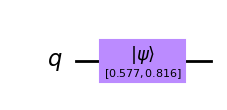

In [54]:
qc =QuantumCircuit(1)
initial_state = [1/sqrt(3), sqrt(2)/sqrt(3)]
qc.initialize(initial_state, 0) # Initialize the 0th qubit in the state `initial_state`
qc.decompose().decompose().decompose()
qc.draw('mpl')

In [42]:
np.arcsin(-sqrt(1)/sqrt(3))

-0.6154797086703875

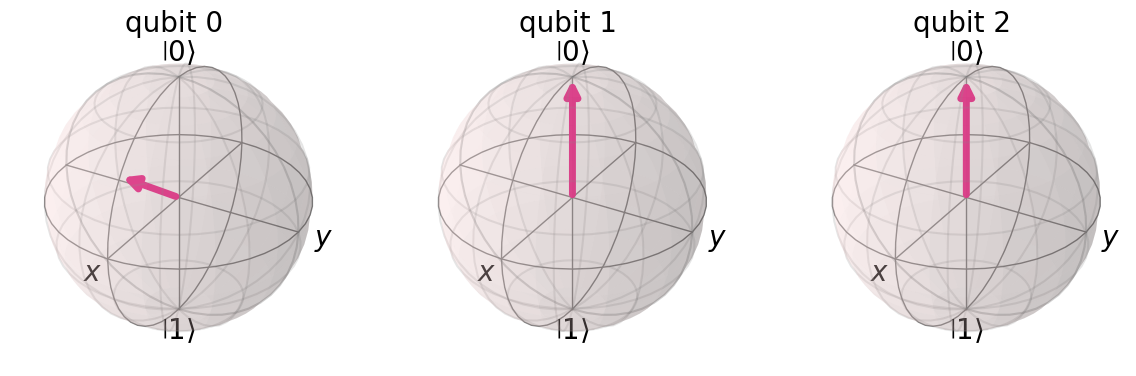

In [30]:
stage2 = QuantumCircuit(3)
stage2.ry(np.arccos(1/sqrt(3)), 0)
Statevector(stage2).draw('bloch')

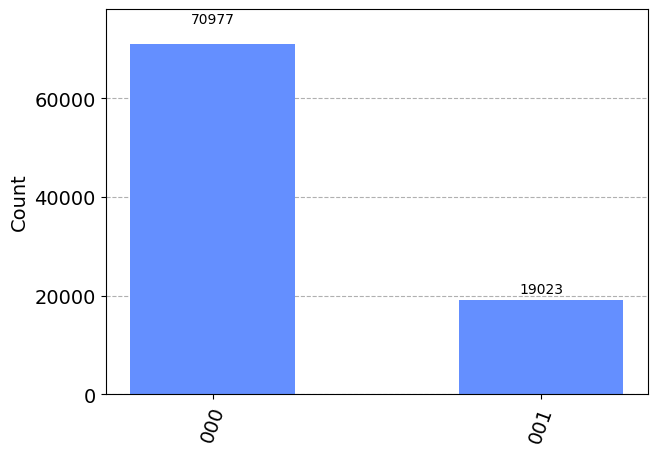

In [36]:
plot_histogram(Statevector(stage2).sample_counts(90000))

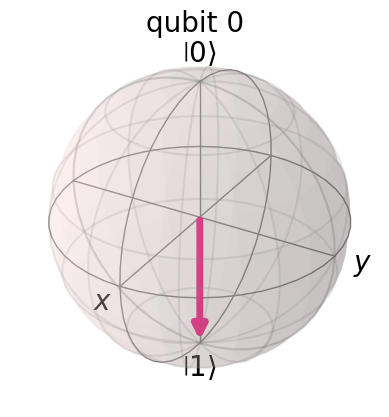

In [30]:
h_gate.h(0)
Statevector(h_gate).draw('bloch')

### Multi Qubit Gate

다중 큐비트 게이트를 알아보기 전, 다중 큐비트 상태의 표현법 (tensor product)에 대해 알아봅시다. 두개의 큐비트로 이루어진 시스템을 생긱하 봅시다. 
$A$와 $B$가 각각의 큐비트에 작용한다고 할때 두 연산자의 텐서곱 $A \otimes B$은 다음과 같습니다.

$$\begin{equation}
	A\otimes B = 
	\begin{pmatrix} 
		A_{00} \begin{pmatrix} 
			B_{00} & B_{01} \\
			B_{10} & B_{11}
		\end{pmatrix} & A_{01} 	\begin{pmatrix} 
				B_{00} & B_{01} \\
				B_{10} & B_{11}
			\end{pmatrix} \\
		A_{10} 	\begin{pmatrix} 
					B_{00} & B_{01} \\
					B_{10} & B_{11}
				\end{pmatrix} & A_{11} 	\begin{pmatrix} 
							B_{00} & B_{01} \\
							B_{10} & B_{11}
						\end{pmatrix}
	\end{pmatrix},						
\end{equation}$$

같은 방식으로 2 큐비트 시스템의 계산 기저도 같은 방식으로 단일큐비트의 계산 기저로 부터 만들어 집니다. 

$$\begin{equation}\begin{split}
	\left|{00}\right\rangle &= \begin{pmatrix} 
		1 \begin{pmatrix} 
			1  \\
			0
		\end{pmatrix} \\
		0 \begin{pmatrix} 
			1  \\
			0 
		\end{pmatrix}
	\end{pmatrix} = \begin{pmatrix} 1 \\ 0 \\ 0 \\0 \end{pmatrix}~~~\left|{01}\right\rangle = \begin{pmatrix} 
	1 \begin{pmatrix} 
	0 \\
	1
	\end{pmatrix} \\
	0 \begin{pmatrix} 
	0  \\
	1 
	\end{pmatrix}
	\end{pmatrix} = \begin{pmatrix}0 \\ 1 \\ 0 \\ 0 \end{pmatrix}\end{split}
\end{equation}$$
    
$$\begin{equation}\begin{split}\left|{10}\right\rangle = \begin{pmatrix} 
	0\begin{pmatrix} 
	1  \\
	0
	\end{pmatrix} \\
	1\begin{pmatrix} 
	1 \\
	0 
	\end{pmatrix}
	\end{pmatrix} = \begin{pmatrix} 0 \\ 0 \\ 1 \\ 0 \end{pmatrix}~~~ 	\left|{11}\right\rangle = \begin{pmatrix} 
	0 \begin{pmatrix} 
	0  \\
	1
	\end{pmatrix} \\
	1\begin{pmatrix} 
	0  \\
	1 
	\end{pmatrix}
	\end{pmatrix} = \begin{pmatrix} 0 \\ 0 \\ 0 \\1 \end{pmatrix}\end{split}
\end{equation}.$$


#### Controlled Gate

대부분의 2 큐비트 게이트들은 SWAP 게이트를 제외하면 대부분 제어 연산의 형태입니다. 일반적으로 제어 연산의 경우 제어 비트와 대상 비트, 그리고 대상 비트에 적용될 단일 큐비트 유니터리 연산자 $U$ 로 정의됩니다. 
임의의 $U$를 다음과 같이 생각해 봅시다.

$$U = \begin{pmatrix} u_{00} & u_{01} \\ u_{10} & u_{11}\end{pmatrix}$$

이 연산자를 사용한 제어 연산은 다음과 같이 생각 해 볼 수 있습니다. **control qubit**가 **qubit 0** 이고, **control qubit**가  **qubit 1**인 경우를 생각해 봅시다. 이 경우 제어 연산은 **qubit 0**이 1일때 $U$를  **qubit 1**에 적용하기 때문에 계산 기저는 다음과 같이 영향을 받게 됩니다. 

$$\begin{align*}
C_{U}: \underset{\text{qubit}~1}{\left|0\right\rangle}\otimes \underset{\text{qubit}~0}{\left|0\right\rangle} &\rightarrow \underset{\text{qubit}~1}{\left|0\right\rangle}\otimes \underset{\text{qubit}~0}{\left|0\right\rangle}\\
C_{U}: \underset{\text{qubit}~1}{\left|0\right\rangle}\otimes \underset{\text{qubit}~0}{\left|1\right\rangle} &\rightarrow \underset{\text{qubit}~1}{U\left|0\right\rangle}\otimes \underset{\text{qubit}~0}{\left|1\right\rangle}\\
C_{U}: \underset{\text{qubit}~1}{\left|1\right\rangle}\otimes \underset{\text{qubit}~0}{\left|0\right\rangle} &\rightarrow \underset{\text{qubit}~1}{\left|1\right\rangle}\otimes \underset{\text{qubit}~0}{\left|0\right\rangle}\\
C_{U}: \underset{\text{qubit}~1}{\left|1\right\rangle}\otimes \underset{\text{qubit}~0}{\left|1\right\rangle} &\rightarrow \underset{\text{qubit}~1}{U\left|1\right\rangle}\otimes \underset{\text{qubit}~0}{\left|1\right\rangle}\\
\end{align*}.$$

이것을 행렬의 형태로 작성해 보면 $C_{U}$연산은 다음과 같이 정리할 수 있습니다.

$$\begin{equation}
	C_U = \begin{pmatrix}
	1 & 0 & 0 & 0 \\
	0 & u_{00} & 0 & u_{01} \\
	0 & 0 & 1 & 0 \\
	0 & u_{10} &0 & u_{11}
		\end{pmatrix}.
\end{equation}$$


이제 **qubit 1**이 제어 비트이고 **qubit 0** 대상 비트가 되는 경우를 생각해 봅시다. 이 경우 계산 기저는 

$$\begin{align*}
C_{U}: \underset{\text{qubit}~1}{\left|0\right\rangle}\otimes \underset{\text{qubit}~0}{\left|0\right\rangle} &\rightarrow \underset{\text{qubit}~1}{\left|0\right\rangle}\otimes \underset{\text{qubit}~0}{\left|0\right\rangle}\\
C_{U}: \underset{\text{qubit}~1}{\left|0\right\rangle}\otimes \underset{\text{qubit}~0}{\left|1\right\rangle} &\rightarrow \underset{\text{qubit}~1}{\left|0\right\rangle}\otimes \underset{\text{qubit}~0}{\left|1\right\rangle}\\
C_{U}: \underset{\text{qubit}~1}{\left|1\right\rangle}\otimes \underset{\text{qubit}~0}{\left|0\right\rangle} &\rightarrow \underset{\text{qubit}~1}{\left|1\right\rangle}\otimes \underset{\text{qubit}~0}{U\left|0\right\rangle}\\
C_{U}: \underset{\text{qubit}~1}{\left|1\right\rangle}\otimes \underset{\text{qubit}~0}{\left|1\right\rangle} &\rightarrow \underset{\text{qubit}~1}{\left|1\right\rangle}\otimes \underset{\text{qubit}~0}{U\left|1\right\rangle}\\
\end{align*},$$

위와 같이 변하게 되고 이것을 행렬의 형태로 정리하면 아래와 같게 됩니다. 

$$\begin{equation}
	C_U = \begin{pmatrix}
	1 & 0 & 0  & 0 \\
	0 & 1 & 0 & 0 \\
	0 & 0 & u_{00} & u_{01} \\
	0 & 0 & u_{10} & u_{11}
		\end{pmatrix}.
\end{equation}$$

#### CX 게이트

이제 가장 많이 사용하게 되는 제어 연산 중 하나인 Controlled-X, CX 게이트에 대해서 살펴봅시다. CX 연산은 제어 큐비트가 1일때 X 게이트를 적용하는 연산으로 제어 큐비트가 큐비트 1, 대상 큐비트가 큐비트 0일때 위의 행렬식과 같이 아래와 같은 행렬식을 갖게 되며, 10과 11상태를 서로 교환하는 것으로 이해하기도 합니다.

$$
C_X = 
\begin{pmatrix}
1 & 0 & 0 & 0\\
0 & 1 & 0 & 0\\
0 & 0 & 0 & 1\\
0 & 0 & 1 & 0
\end{pmatrix}. 
$$

반대로, 제어 큐비트가 큐비트 0, 대상 큐비트가 큐비트 1이라면 아래와 같아 지며 01과 11의 상태를 서로 교환하는 것으로 이해하기도 합니다.

$$
C_X = 
\begin{pmatrix}
1 & 0 & 0 & 0\\
0 & 0 & 0 & 1\\
0 & 0 & 1 & 0\\
0 & 1 & 0 & 0
\end{pmatrix}. 
$$

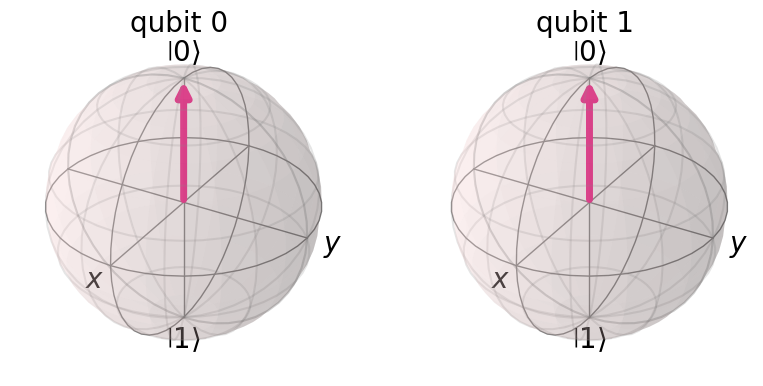

In [33]:
cx_gate = QuantumCircuit(2)
Statevector(cx_gate).draw('bloch')

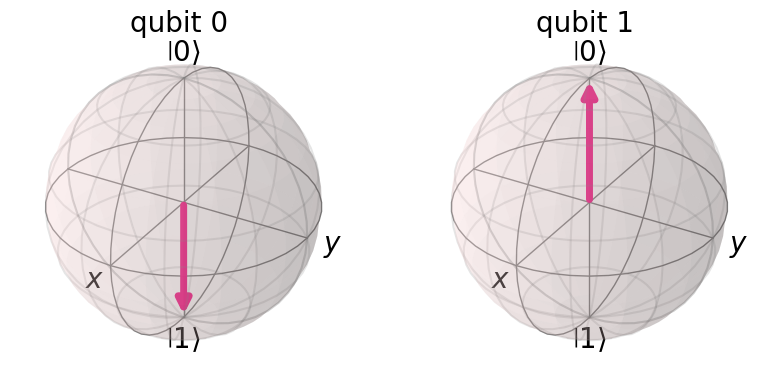

In [34]:
cx_gate.x(0)
Statevector(cx_gate).draw('bloch')

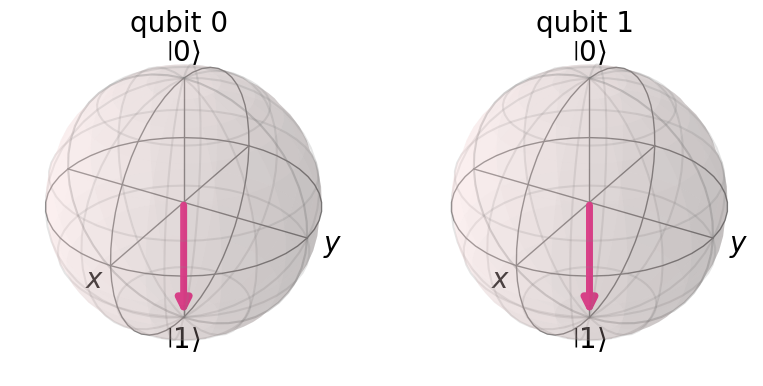

In [35]:
cx_gate.cx(0,1)
Statevector(cx_gate).draw('bloch')

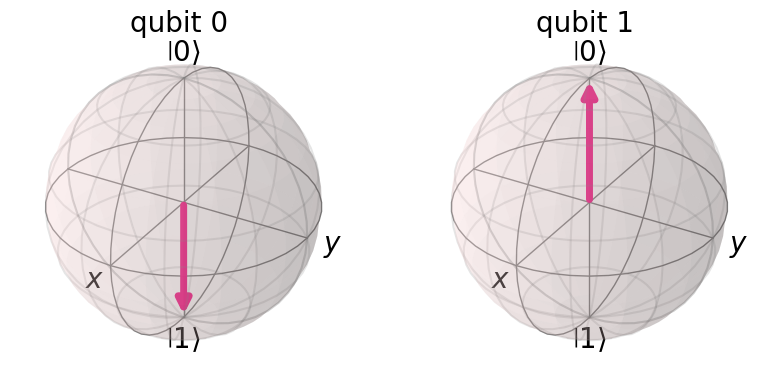

In [36]:
cx_gate.cx(0,1)
Statevector(cx_gate).draw('bloch')

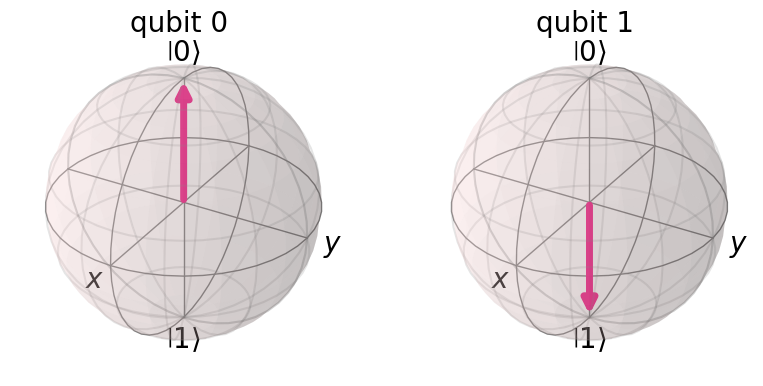

In [37]:
cx_gate.x([0,1])
Statevector(cx_gate).draw('bloch')

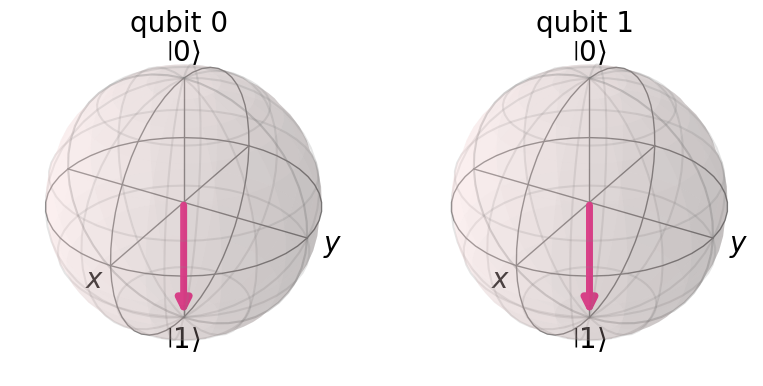

In [38]:
cx_gate.cx(1,0)
Statevector(cx_gate).draw('bloch')

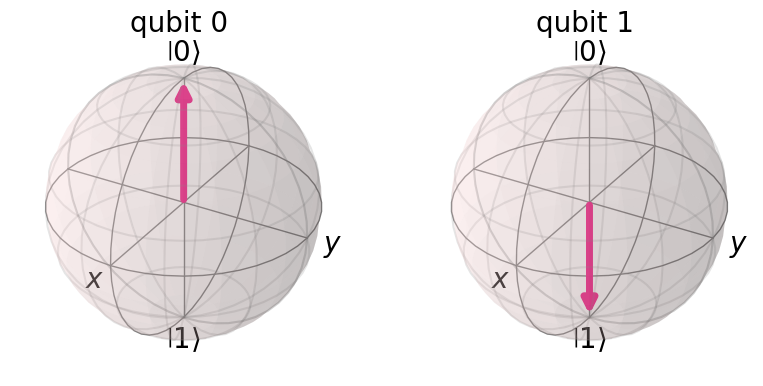

In [39]:
cx_gate.cx(1,0)
Statevector(cx_gate).draw('bloch')

#### SWAP gate

스왑 게이트는 두 큐비트의 상태를 통째로 교환합니다. 이 게이트는 계산 기저를 다음과 같이 변환합니다. 

$$\left|00\right\rangle \rightarrow \left|00\right\rangle~,~\left|01\right\rangle \rightarrow \left|10\right\rangle~,~\left|10\right\rangle \rightarrow \left|01\right\rangle~,~\left|11\right\rangle \rightarrow \left|11\right\rangle,$$

이 연산은 행렬로 표현하면 다음과 같습니다. 

$$
\mathrm{SWAP} = 
\begin{pmatrix}
1 & 0 & 0 & 0\\
0 & 0 & 1 & 0\\
0 & 1 & 0 & 0\\
0 & 0 & 0 & 1
\end{pmatrix}.
$$

Swap 게이트의 성능을 확인하기 위해 각각의 큐비트를 임의의 상태벡터로 초기화 해보도록 합시다.

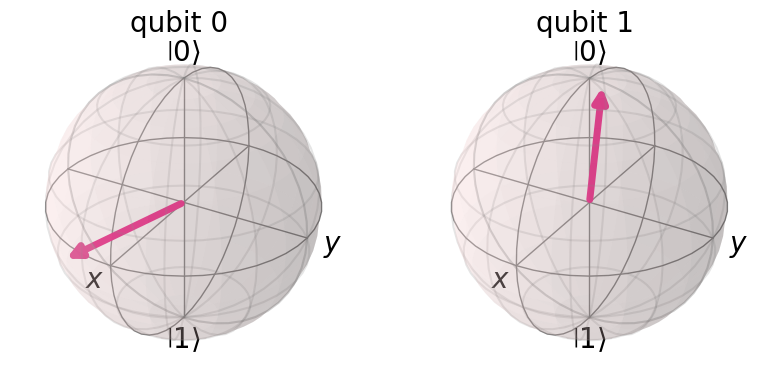

In [46]:
swap_gate = QuantumCircuit(2)
initial_1 = random_statevector(2)   
initial_2 = random_statevector(2)   
swap_gate.initialize(initial_1, 0)
swap_gate.initialize(initial_2, 1)
Statevector(swap_gate).draw('bloch')

In [47]:
array_to_latex(Statevector(swap_gate))

<IPython.core.display.Latex object>

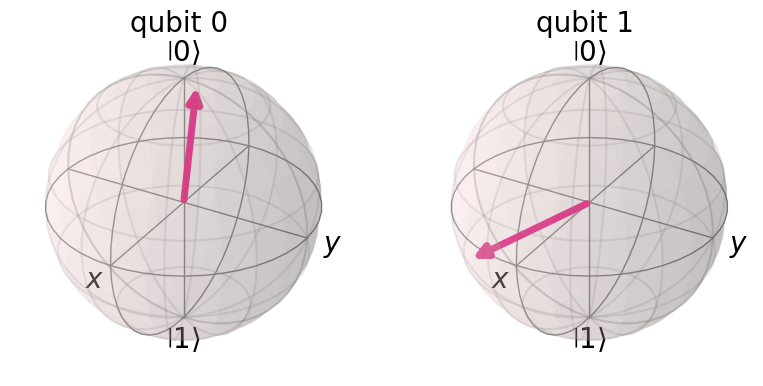

In [48]:
swap_gate.swap(0,1)
Statevector(swap_gate).draw('bloch')

In [49]:
array_to_latex(Statevector(swap_gate))

<IPython.core.display.Latex object>

### 측정


큐비트는 여러가지 중첩 가능한 상태로 초기화 되어 사용 될 수 있습니다. 하지만 한번 측정되고 난 후에는 $|0\rangle$이나 $|1\rangle$로 그 상태가 결정됩니다. 이것을 측정이 큐비트의 상태를 0또는 1로 붕괴시킨다고 표현하곤 합니다. 

다음의 실습에서 measurement를 포함하거나 포함하지 않은, 두가지 회로를 구성하고, 각 경우 최종 회로의 statevector값을 확인해 봅시다. 큐비트의 초기 값은  0과 1로 측정될 확률이 각각 50%에 해당하는 텍스트북에 제시된 상태를 사용하도록 하겠습니다.

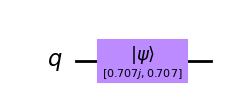

In [50]:
#측정이 없는 회로

qc_without_measurment = QuantumCircuit(1) # We are redefining qc
initial_state = [0.+1.j/sqrt(2),1/sqrt(2)+0.j]
qc_without_measurment.initialize(initial_state, 0)
qc_without_measurment.draw('mpl')


In [54]:
backend = StatevectorSimulator()
backend.run(qc_without_measurment).result().get_statevector()

Statevector([0.        +0.70710678j, 0.70710678+0.j        ],
            dims=(2,))


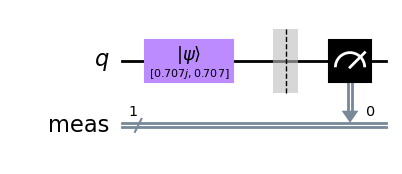

In [55]:

qc_with_measurment = QuantumCircuit(1) # We are redefining qc
initial_state = [0.+1.j/sqrt(2),1/sqrt(2)+0.j]
qc_with_measurment.initialize(initial_state, 0)
qc_with_measurment.measure_all()
qc_with_measurment.draw('mpl')


In [57]:
backend = StatevectorSimulator()
backend.run(qc_with_measurment).result().get_statevector()

Statevector([0.+1.j, 0.+0.j],
            dims=(2,))


바로 위의 셀을 여러번 실행시켜 보면 statevector의 값이 0 또는 1에 해당하게 계속 변하는 것을 볼수있습니다. 마치 동전던지기와 같습니다 :)

### A Note about Quantum Simulators

`qiskit_aer`는 Qiskit의 시뮬레이션 패키지로, 다음과 같은 시뮬레이터 들을 보유하고 있습니다
- [AerSimulator](https://qiskit.org/ecosystem/aer/stubs/qiskit_aer.AerSimulator.html#qiskit_aer.AerSimulator)
- [QasmSimulator](https://qiskit.org/ecosystem/aer/stubs/qiskit_aer.QasmSimulator.html#qiskit_aer.QasmSimulator)
- [StatevectorSimulator](https://qiskit.org/ecosystem/aer/stubs/qiskit_aer.StatevectorSimulator.html#qiskit_aer.StatevectorSimulator)
- [UnitarySimulator](https://qiskit.org/ecosystem/aer/stubs/qiskit_aer.UnitarySimulator.html#qiskit_aer.UnitarySimulator)

이 중 `AerSimulator`는 회로를 실행하고 측정된 값의 count를 반환합니다. 노이즈가 없는 이상적인 시뮬레이션을 하며 실행의 기본값은 `shots=1024`로 회로를 1024번 실행하도록 하고 있습니다. 

### Bloch Sphere vs QSphere

Qiskit은 양자 상태를 visual하고, 직관적으로 보여주기 위해 세가지 라이브러리를 제공하고 있습니다. 
- [plot_bloch_vector](https://qiskit.org/documentation/stubs/qiskit.visualization.plot_bloch_vector.html) (입력이 구면의 좌표, Cartesian or Spherical)
- [plot_bloch_multivector](https://qiskit.org/documentation/stubs/qiskit.visualization.plot_bloch_multivector.html) (입력이 statevector)
- [plot_state_qsphere](https://qiskit.org/documentation/stubs/qiskit.visualization.plot_state_qsphere.html) (입력이 statevector)

다음의 실습에서는 임의의 양자상태를 생성하고, 세가지 라이브러리를 사용해 큐비트의 상태를 표현해 보도록 하겠습니다.

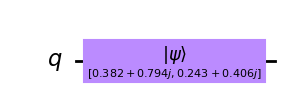

In [58]:
from qiskit.visualization import plot_state_qsphere, plot_bloch_vector, plot_bloch_multivector

qc = QuantumCircuit(1)
initial_state = random_statevector(2) 
qc.initialize(initial_state, 0)

qc.draw('mpl')

In [59]:
def get_spherical_coordinates(statevector):
    # Convert to polar form:
    r0 = np.abs(statevector[0])
    ϕ0 = np.angle(statevector[0])

    r1 = np.abs(statevector[1])
    ϕ1 = np.angle(statevector[1])

    # Calculate the coordinates:
    r = np.sqrt(r0 ** 2 + r1 ** 2)
    θ = 2 * np.arccos(r0 / r)
    ϕ = ϕ1 - ϕ0
    return [r, θ, ϕ]

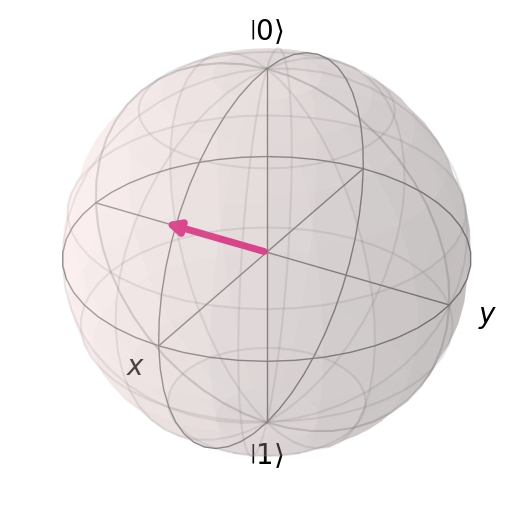

In [60]:
plot_bloch_vector(get_spherical_coordinates(initial_state), coord_type = 'spherical')

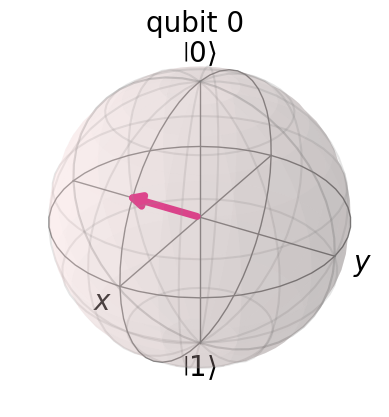

In [61]:
plot_bloch_multivector(initial_state)

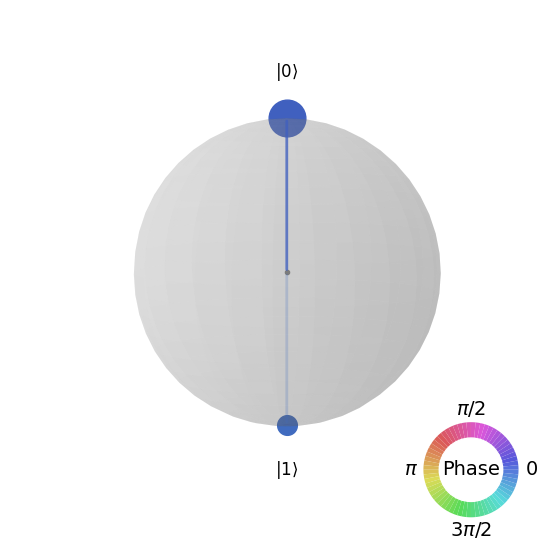

In [62]:
plot_state_qsphere(initial_state)

이제 우리의 Quantum Journey의 첫번째 관문에 거의 다다랐습니다. 문제를 확인해 봅시다. 

# 양자 세계로 들어가는 진짜 문을 찾아라

(contents from: [The Quantum Enigmas 001 - The treasure door](https://www.youtube.com/watch?v=c1beJIg8lRs) of Institut quantique de l'Université de Sherbrooke)

<img src="img/enigma1.png" alt="Alternative text" width=800/>

여러분은 각각 문지기가 지키고 있는 두개의 문 앞에 다다랐습니다. 

1. 두개의 문 중 하나만이 진짜 양자세계로 가는 문 입니다.
2. 두 문지기는 모두 진짜 문이 무엇인지 알고 있습니다.
3. 문지기 중 한명은 늘 진실만은 이야기 합니다.
4. 문지기 중 나머지 하나는 늘 거짓만을 이야기 합니다.
5. 여러분은 문지기 중 단 한명에게 단 하나의 질문만을 던져서 진짜 문을 찾아내야 합니다.

자, 이 문제를 양자게이트들을 사용해서 해결해 봅시다. 

## 첫번째 단계 - 두 문지기는 같은 것을 알고 있다 - Quantum Entanglement

우선 두 문지기는 오른쪽 문(0)이 진짜 문인지 왼쪽 문(1)이 진짜 문인지를 알고 있습니다. 오른쪽 문지기를 큐비트0, 왼쪽 문지기를 큐비트 1이라 한다면 진짜문이 각각 오른쪽과 왼쪽인 경우 큐비트의 상태는 다음과 같아야 합니다.

- 오른쪽 문이 진짜 문인 경우, 0번 큐비트의 상태는 0, 1번 큐비트의 상태는 0 -> $|00\rangle$
- 왼쪽 문이 진짜 문인 경우, 0번 큐비트의 상태는 1, 1번 큐비트의 상태는 1 -> $|11\rangle$

두개의 문지기 큐비트가 이와 같은 상태를 갖도록 양자 회로를 만들어 봅시다.

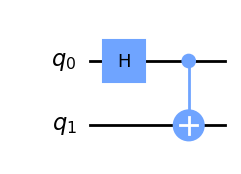

In [84]:
state1 = QuantumCircuit(2)
state1.h(0)
state1.cx(0,1)
state1.draw('mpl')

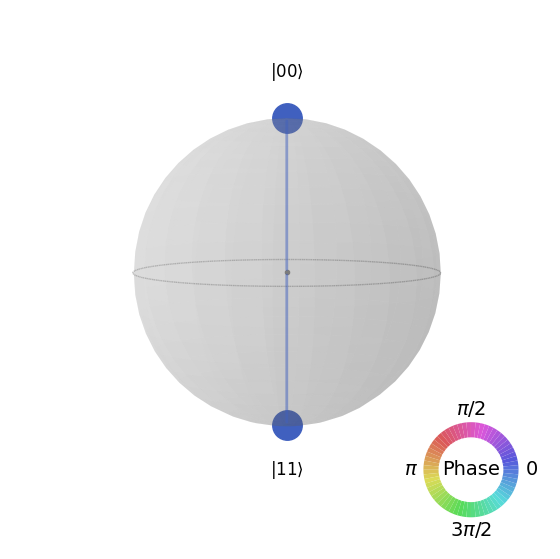

In [85]:
Statevector(state1).draw('qsphere')

네 두 문지기는 어느 문이 진짜 문인지, 같은 정보를 나눠갖고 있는 상태가 되었습니다. 이 상태는 얽힘 상태라고 표현합니다. 즉, 두개의 큐비트의 상태가 항상 같은 값이나 반대 값으로 묶여 있다고 볼 수 있으며, 수학적으로 이런 얽힘 상태는 위에서 배운 텐서곱을 사용해 두개의 단일 큐비트 상태의 곱으로 `나눌 수 없`습니다.

## 두번째 단계 - 두 문지기 중에 거짓말 장이가 있다

두 문지기는 같은 것을 알고 있지만, 둘중에 하나는 거짓말을 하고 있습니다. 이 경우 거짓말 쟁이가 알고 있는 정보는 반전되게 됩니다. 이 부분을 추가 적인 큐비트 - 거짓말 쟁이 큐비트 - 를 만들어서 구현해 보도록 합시다.

우선 거짓말쟁이 큐비트를 하나 지정한 후 회로에 추가해 봅시다.


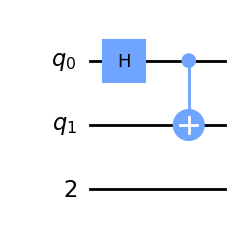

In [86]:
lier = QuantumRegister(1)
state1.add_bits(lier)
state1.draw('mpl')

거짓말쟁이는 왼쪽 문지기, 오른쪽 문지기 중 하나이므로 중첩 상태를 만듭니다. 

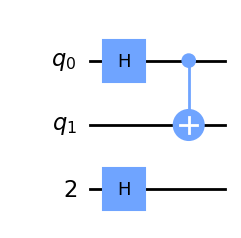

In [87]:
state1.h(2)
state1.draw('mpl')

그리고 이제 거짓말쟁이 큐비트를 사용해 다음과 같은 기능을 구현해 봅니다.

1. 오른쪽 문지기가 거짓말쟁이라면 (거짓말 쟁이 큐비트가 0의 상태라면) Q0의 정보를 반전시킨다
2. 왼쪽 문지기가 거짓말쟁이라면 (거짓말쟁이 큐비트가 1의 상태라면) Q1의 정보를 반전시킨다.

이 기능을 x 게이트와 cx 게이트를 사용해 구현해 봅시다. 우선 1번을 구현해 봅시다.

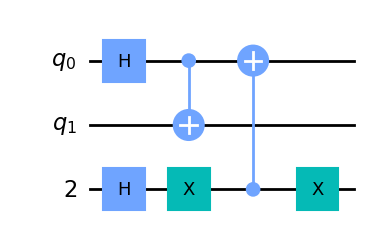

In [88]:
state1.x(2)
state1.cx(2,0)
state1.x(2)
state1.draw('mpl')

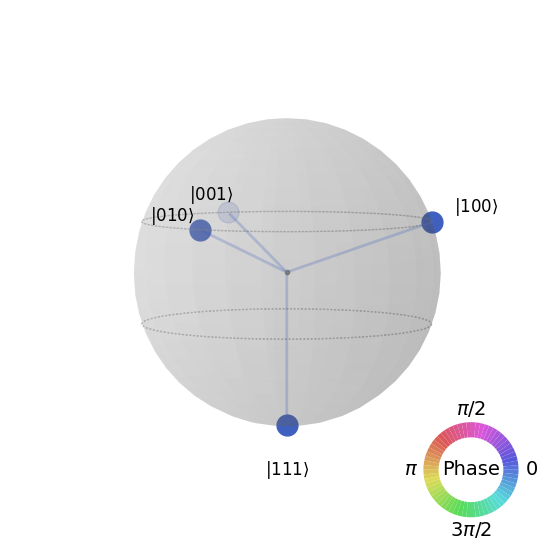

In [89]:
Statevector(state1).draw('qsphere')

다음으로 2번을 구현해 봅시다.

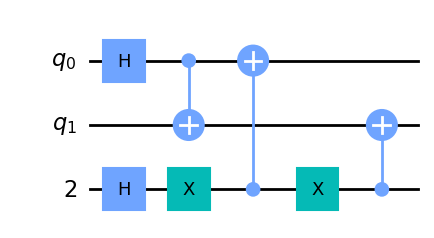

In [90]:
state1.cx(2,1)

state1.draw('mpl')

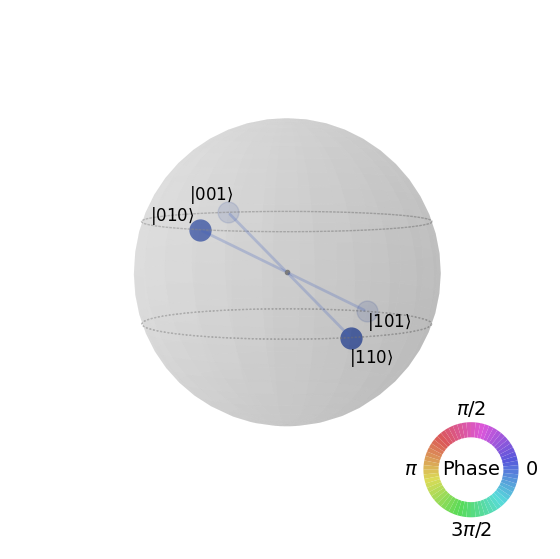

In [91]:
Statevector(state1).draw('qsphere')

이제, 둘중 하나의 문지기에게 던질 질문을 준비해 봅시다. 

위의 상태를 자세히 살펴 봅시다.
1. 오른쪽 문지기가 거짓말쟁이인 경우, 정답은 왼쪽 문지기의 정답
- $|001\rangle$: 정답 - 오른쪽, 오른쪽 문지기가 거짓말쟁이이고, 왼쪽 문지기는 오른쪽 문이 진짜 문이라고 대답할것이며, 오른쪽 문지기는 왼쪽 문이 진짜문이라고 대답할 것이다.
- $|010\rangle$: 정답 - 왼쪽, 오른쪽 문지기가 거짓말쟁이이고, 왼쪽 문지기는 왼쪽 문이 진짜 문이라고 대답할것이며, 오른쪽 문지기는 오른쪽 문이 진짜문이라고 대답할 것이다.

이 경우 두 문지기가 같은 답을 하게 하는 가장 쉬운 방법은 둘 중 하나의 문지기에게 "반대편 문지기가 어떤 문을 열지 말라고 할지" 물어보는 것입니다. $|001\rangle$인 경우를 생각해 봅시다. 이 경우 진실은 오른쪽 문(0)입니다.

- 오른쪽 문지기에게 질문할 경우: 왼쪽 문을 열지 말라고 말하려다가 다시 거짓말을 할것이기 때문에 오른쪽 문을열지 말라고 말할 것입니다.  $|001\rangle$ $\rightarrow$ $|000\rangle$
- 왼쪽 문지기에게 오른쪽 문지기가 어떤 문을 나에게 열지 말지 물어보면: 오른쪽 문을 열지 말라고 말할 것입니다.  $|001\rangle$ $\rightarrow$ $|000\rangle$

위에서 알 수 있듯이 반대편 문지기가 어떤 문을 열지 말라고 물어볼 경우 두 문지기 모두 진실을 말하게 됨을 알 수 있습니다. 다른 상황에서도 이와 같음을 논리표를 그려서 확인해 봅시다.


| liar      | correct answer | current answer | asked | final answer |
| ----------- | ----------- | ------------| ------| ------ |
| 0 | 0 | 01 | 0 | 00 |
| 0 | 0 | 01 | 1 | 00 |
| 0 | 1 | 10 | 0 | fill this! |
| 0 | 1 | 10 | 1 | fill this! |
| 1 | 1 | 01 | 0 | fill this! |
| 1 | 1 | 01 | 1 | fill this! |
| 1 | 0 | 10 | 0 | fill this! |
| 1 | 0 | 10 | 1 | fill this! |

그럼 우리의 양자 회로에 이 질문 "다른 문지기가 어떤 문을 열지 말라고 할지"를 코딩해 봅시다. 우선 질문을 하는 문지기의 답이 상대방의 답의 상태로 바뀌게 되므로 Swap 게이트를 회로에 적용합니다.

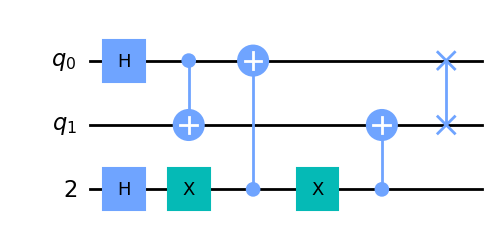

In [92]:
state1.swap(0,1)
state1.draw('mpl')


다음으로 열지 말것을 물어보고 있으므로 x 게이트를 적용합니다.

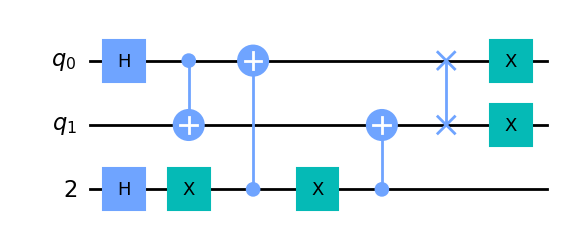

In [93]:
state1.x([0,1])
state1.draw('mpl')


마지막으로 거짓말쟁이는 다시 거짓말을 할 것이므로, 거짓말 쟁이 회로를 다시 한번 적용합니다.

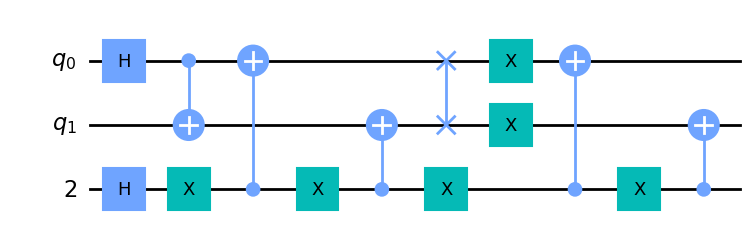

In [94]:
state1.x(2)
state1.cx(2,0)
state1.x(2)
state1.cx(2,1)
state1.draw('mpl')

이제 이 회로를 측정해서 결과를 확인해 봅시다.

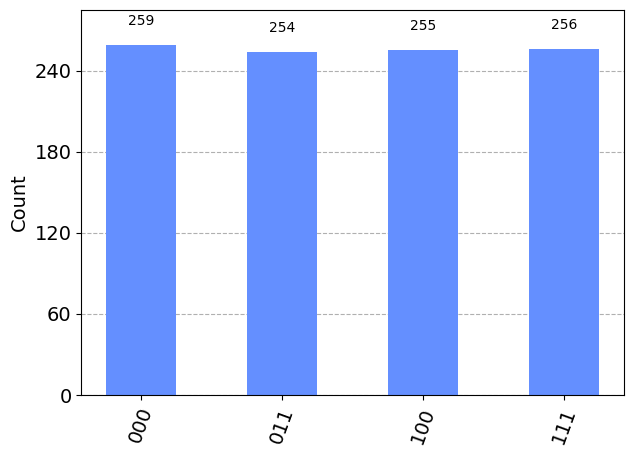

In [95]:
state1.measure_all()
backend = AerSimulator()
counts = backend.run(state1).result().get_counts()
plot_histogram(counts)

결과를 살펴 봅시다. "상대방 문지기가 열지 말라고 할 문"을 둘중 하나의 문지기에게 한번 물어보는 경우, 어느쪽 문이 진짜 문인지, 어느 문지기가 거짓말 쟁이인지에 관계 없이 두 문지기는 진실만을 이야기 하게 되어 있습니다. 

# 축하합니다! 첫번째 관문을 통과했습니다. 이제 두번째 관문을 향해 이동해 봅시다.